In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *

from jax import random
import sys

# Lambda_idx = int(sys.argv[1])
# n_bins = int(sys.argv[2])
# n_mc_points = int(sys.argv[3]) **2
# bin1_idx = int(sys.argv[4])
# bin2_idx = int(sys.argv[5])



Lambda_idx = 18
n_bins = 100

n_mc_points = 30 **2
bin1_idx = 3
bin2_idx = 3


In [2]:
Lambda = Lambdas[Lambda_idx]

# CCAT-prime
zmin = 3.5
zmax = 8.1

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
oup_fname +='zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_bins_%d_mc_%d_quad_%d_%d.npy'%(zmin, zmax, 
                                                                                      Lambda_idx, 
                                                                                      n_bins,
                                                                                      int(np.sqrt(n_mc_points)),
                                                                                      bin1_idx,
                                                                                      bin2_idx)
print(oup_fname)

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid


inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')

import jax
import jax.numpy as jnp
_KI = np.array(KI)
@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))

from interpax import interp2d, interp1d
inner_dkparp_integral = jnp.array(inner_dkparp_integral.astype(np.float64))
inner_dkparp_integral = jnp.moveaxis(inner_dkparp_integral, 0, -1)

chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
dchi = np.mean(np.diff(chi_bin_edges))
print(dchi)
print(np.sqrt(n_mc_points))

from tqdm import trange

/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_3.5_zmax_8.1_Lambda_idx_18_n_bins_100_mc_30_quad_3_3.npy


2025-03-05 19:55:08.046515: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


22.095378626532902
30.0


In [3]:
@jax.jit
def f_integrand(_chib,
                bin1_idx,
                bin2_idx,
                l1,
                r1,
                l2,
                r2,
               _iter):
    key = random.key(bin1_idx+bin2_idx*11234+_iter*112345678) 
    key1, key2 = random.split(key)
    external_chis = random.uniform(key1, shape=(n_mc_points,),
                                  minval = l1, maxval=r1)
    external_chips = random.uniform(key2, shape=(n_mc_points,),
                                  minval = l2, maxval=r2)
    
    #by construction chimin < exteranl_chis < chimax 
    #I Lo + Lo I
    _delta = jnp.abs(1 - external_chis/_chib) #p
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chis) 
            & (2*_chib - external_chis <= chimax)) #(p)
    
                           
    cross_integrand = jnp.where(_idx,
                                2 * jnp.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0) 
                                * f_KILo(2*_chib - external_chis,
                                         external_chi = external_chips,
                                         Lambda=Lambda)
                                / (_chib**2),
                                0)
    cross_integrand = (cross_integrand.reshape(-1, 1) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                                  x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
                                  method='linear',))


    _delta = jnp.abs(1 - external_chips/_chib) #(n_ext)
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chips) 
            & (2*_chib - external_chips <= chimax)) #(n_ext)
    
    cross_integrand2 = jnp.where(_idx,
                                 2 * jnp.interp(x = external_chips, xp = chis, fp = _KI, left = 0, right = 0) 
                                 * f_KILo(2*_chib - external_chips, 
                                          external_chi = external_chis, 
                                          Lambda=Lambda)
                                 / (_chib**2), 0)
    
    cross_integrand2 = (cross_integrand2.reshape(-1, 1)
                        * interp2d(xq = _chib, yq=jnp.log(_delta), 
                                   x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
                                   method='linear',))

    plus = _chib*(1+deltas)
    mins = _chib*(1-deltas)
    _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    
    LoLo_integrand  = jnp.where(_idxs,
                               f_KILo(plus, 
                                      external_chi = external_chis.reshape(-1,1), 
                                      Lambda=Lambda) 
                                * f_KILo(mins, 
                                         external_chi = external_chips.reshape(-1,1), 
                                         Lambda=Lambda),
                               0)
    LoLo_integrand += jnp.where(_idxs,
                               f_KILo(mins, 
                                      external_chi = external_chis.reshape(-1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(plus, 
                                         external_chi = external_chips.reshape(-1, 1), 
                                         Lambda=Lambda),0)
    LoLo_integrand *= (2 / _chib) #(p,d)
    LoLo_integrand = jnp.einsum('pd,d,dl->pld', LoLo_integrand, deltas, 
                               interp1d(xq = _chib,
                                         x = chibs, f=inner_dkparp_integral,
                                         method='linear',))
    
    LoLo_integrand = jnp.trapezoid(x = jnp.log(deltas), y = LoLo_integrand, axis=-1)

    return LoLo_integrand - (cross_integrand + cross_integrand2)

In [4]:
from quadax import quadgk
sm = 0
_n = 0

l1, r1 = chi_bin_edges[bin1_idx], chi_bin_edges[bin1_idx + 1]
l2, r2 = chi_bin_edges[bin2_idx], chi_bin_edges[bin2_idx + 1]
bnds = jnp.hstack([jnp.linspace(10, chimin,210), jnp.linspace(chimin, chimax, 9000), jnp.linspace(chimax, chimax_sample,210)])

for _iter in trange(1):
    res, info = quadgk(f_integrand, bnds,
                     epsabs = 0.0, epsrel = 1e-5, 
                    order = 61, max_ninter=9500,
                       full_output = True,
                   args=(bin1_idx,bin2_idx,
                       l1,
                       r1,
                       l2,
                       r2,
                        _iter))
    print(info[1],
          info[3]['ninter'])
    sm += jnp.sum(res, axis=0)
    _n += len(res)

100%|██████████| 1/1 [00:40<00:00, 40.02s/it]

574559 9419


In [5]:
np.save(oup_fname, sm/_n)

In [6]:

def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
#     print('external chi spacing', np.mean(np.diff(external_chis)))
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

comb_n_external = 1500
comb_fname = '/scratch/users/delon/LIMxCMBL/I_auto/old/comb_'
comb_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_jax_quad.npy'%(zmin, zmax, 
                                                                         Lambda_idx, 
                                                                         comb_n_external,)

comb_unbinned = np.load(comb_fname)
comb = get_binned(comb_unbinned, n_external = comb_n_external)


In [7]:
import matplotlib.pyplot as plt


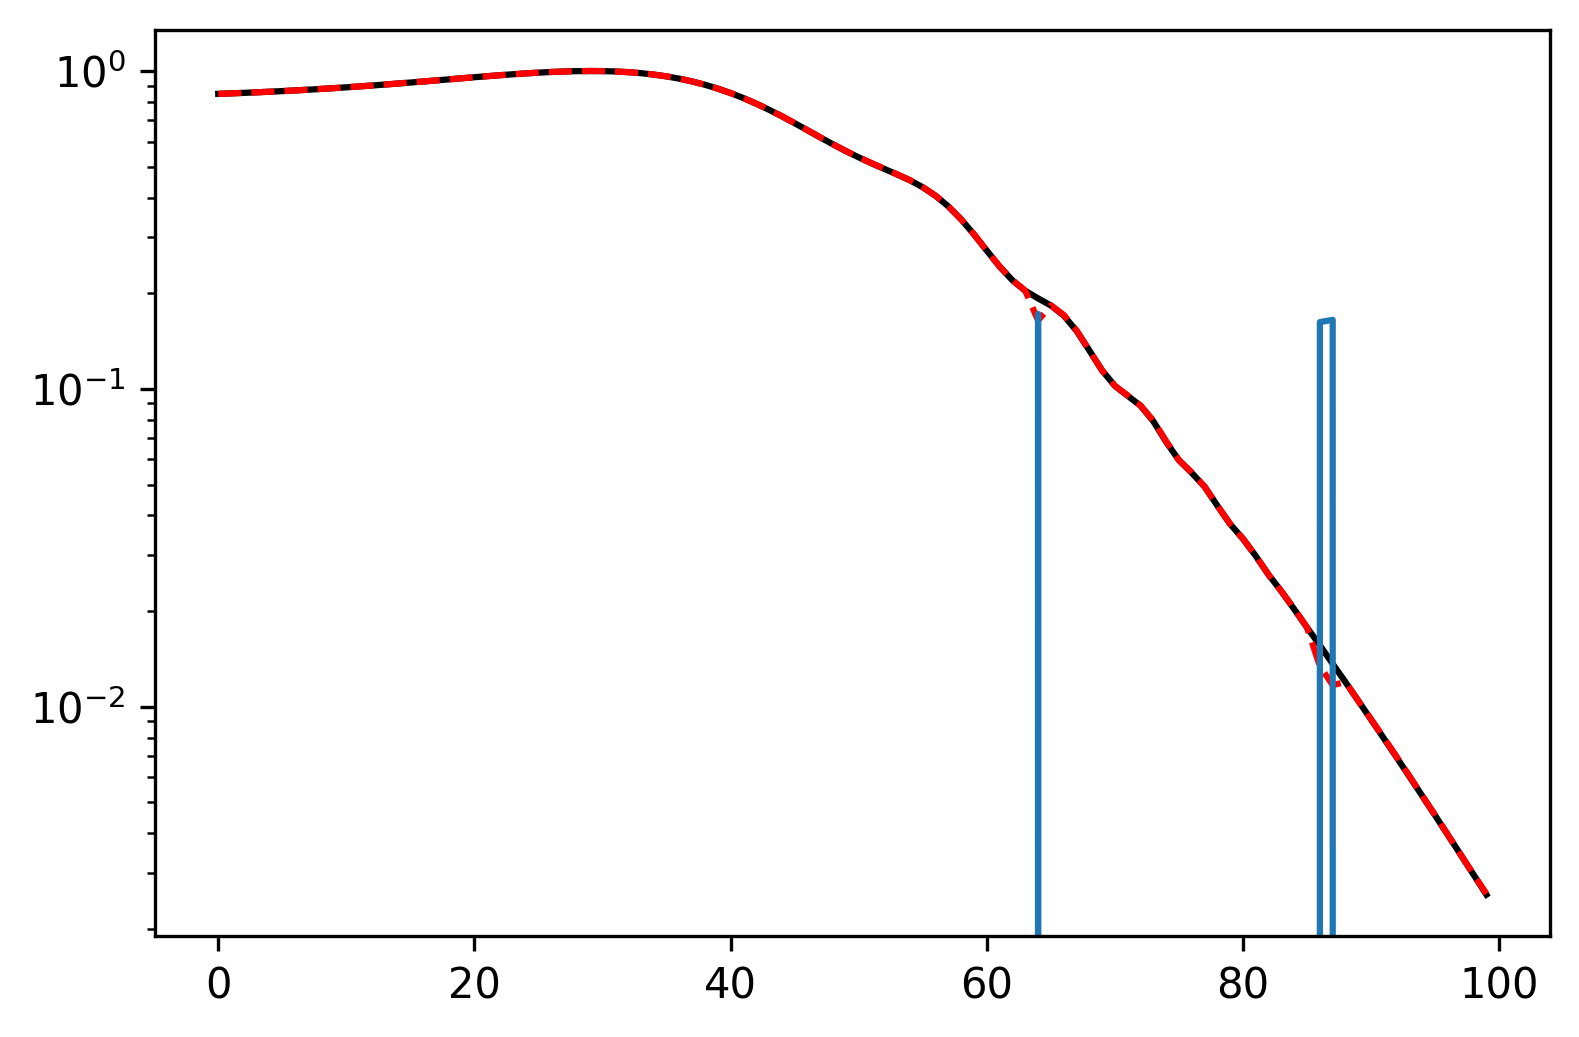

In [14]:
plt.figure(dpi = 300)
plt.plot(-(sm/_n)/jnp.max(jnp.abs(sm/_n)), 'k')
plt.plot(-(comb[:,bin1_idx, bin2_idx])/np.max(np.abs(comb[:,bin1_idx, bin2_idx])), 'r--')

plt.plot((sm/_n-comb[:,bin1_idx, bin2_idx])/(comb[:,bin1_idx, bin2_idx]))
plt.yscale('log')


(-0.8, 0.8)

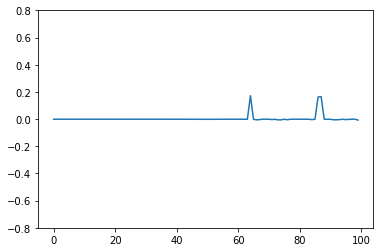

In [9]:
plt.plot((sm/_n-comb[:,bin1_idx, bin2_idx])/(comb[:,bin1_idx, bin2_idx]))
plt.ylim(-.8, .8)

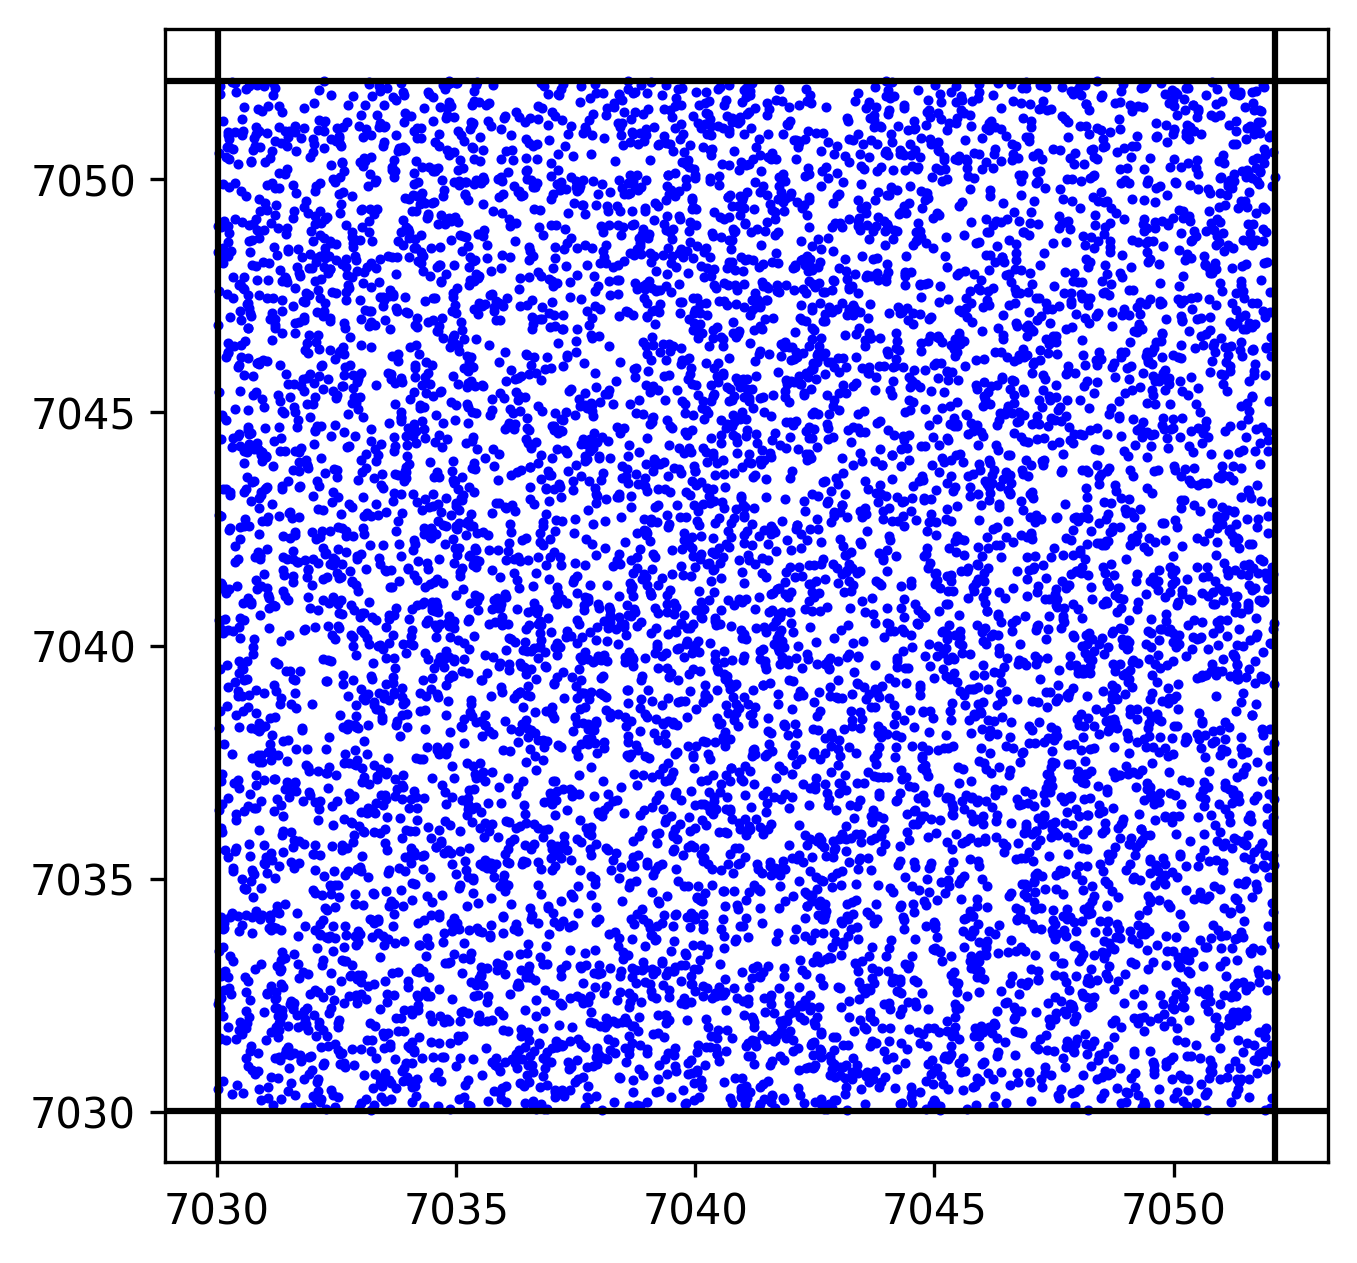

In [10]:
plt.figure(dpi = 300, figsize = (5,5))
for _iter in range(9):
    key = random.key(bin1_idx+bin2_idx*11234+_iter*112345678) 
    key1, key2 = random.split(key)
    external_chis = random.uniform(key1, shape=(n_mc_points,),
                                  minval = l1, maxval=r1)
    external_chips = random.uniform(key2, shape=(n_mc_points,),
                                  minval = l2, maxval=r2)
    plt.scatter(x = external_chis, y = external_chips,s =2, c='b')
plt.axvline(l1, c='k')
plt.axvline(r1, c='k')
plt.axhline(l2, c='k')
plt.axhline(r2, c='k')